In [8]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)

PROJECT_ROOT: E:\DL_audiotomidi


In [9]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from scipy.optimize import nnls
from scipy.ndimage import median_filter
import pretty_midi
import mir_eval

from scripts.nmf_helpers import activations_to_notes, build_w_fixed, denoise_activations, note_name_to_midi
from scripts.evaluate import evaluate_transcription_full

In [10]:
audio, sr = librosa.load('wet_hands.wav', sr=None, mono=True)
print(f"Original sampling rate: {sr} Hz, audio duration: {len(audio)/sr:.2f} sec")

Original sampling rate: 44100 Hz, audio duration: 86.15 sec


In [11]:
target_sr = 8000
if sr > target_sr:
    audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
    sr = target_sr
    print(f"Downsampled audio to {sr} Hz")

Downsampled audio to 8000 Hz


Spectrogram shape: (1025, 1347) (freq_bins x time_frames)


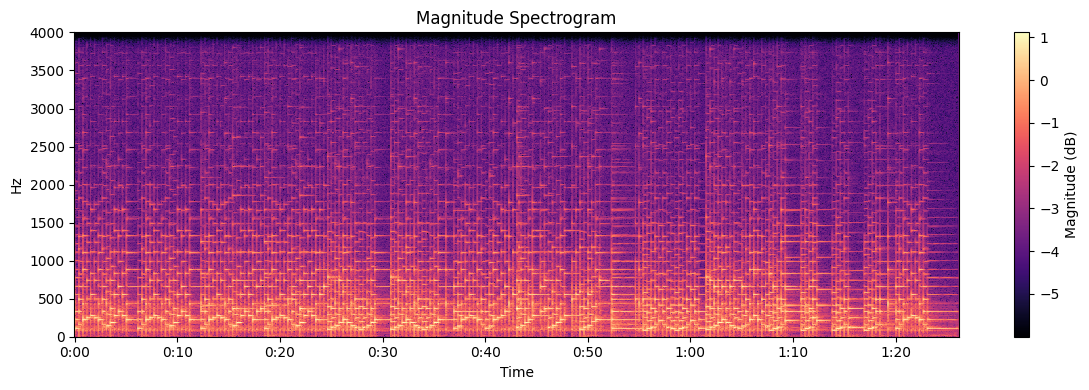

In [16]:
n_fft = 2048
hop_length = 512
D = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
S = np.abs(D)
freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
times = librosa.frames_to_time(np.arange(S.shape[1]), 
                               sr=sr, hop_length=hop_length, n_fft=n_fft)

print(f"Spectrogram shape: {S.shape} (freq_bins x time_frames)")

plt.figure(figsize=(12, 4))
S_db = np.log10(S + 1e-6)
librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(label='Magnitude (dB)')
plt.title("Magnitude Spectrogram")
plt.tight_layout()
plt.show()

In [6]:
num_components = 88
model = NMF(n_components=num_components, init='random', random_state=0, max_iter=200)
W = model.fit_transform(S)
H = model.components_

print("W matrix shape:", W.shape)
print("H matrix shape:", H.shape)

W matrix shape: (1025, 88)
H matrix shape: (88, 1347)


E:\CONDA\envs\amt\Lib\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [7]:
component_pitches_hz = []
for r in range(W.shape[1]):
    freq_index = np.argmax(W[:, r])
    peak_freq = freqs[freq_index]
    component_pitches_hz.append(peak_freq)
    if peak_freq > 0:
        midi_note = int(round(69 + 12 * np.log2(peak_freq/440.0)))
        print(f"Component {r}: strongest frequency ~{peak_freq:.1f} Hz (approx MIDI note {midi_note})")

Component 0: strongest frequency ~175.8 Hz (approx MIDI note 53)
Component 1: strongest frequency ~117.2 Hz (approx MIDI note 46)
Component 2: strongest frequency ~242.2 Hz (approx MIDI note 59)
Component 3: strongest frequency ~191.4 Hz (approx MIDI note 55)
Component 4: strongest frequency ~218.8 Hz (approx MIDI note 57)
Component 5: strongest frequency ~218.8 Hz (approx MIDI note 57)
Component 6: strongest frequency ~105.5 Hz (approx MIDI note 44)
Component 7: strongest frequency ~492.2 Hz (approx MIDI note 71)
Component 8: strongest frequency ~226.6 Hz (approx MIDI note 58)
Component 9: strongest frequency ~277.3 Hz (approx MIDI note 61)
Component 10: strongest frequency ~183.6 Hz (approx MIDI note 54)
Component 11: strongest frequency ~371.1 Hz (approx MIDI note 66)
Component 12: strongest frequency ~207.0 Hz (approx MIDI note 56)
Component 13: strongest frequency ~187.5 Hz (approx MIDI note 54)
Component 14: strongest frequency ~164.1 Hz (approx MIDI note 52)
Component 15: strong

In [8]:
pitches_midi = [
    int(round(69 + 12 * np.log2(f / 440.0)))
    for f in component_pitches_hz
]
detected_notes = activations_to_notes(H, 
                                      times, 
                                      pitches_midi, 
                                      onset_rel_thresh=0.2, 
                                      min_frames=1)

In [9]:
midi_object = pretty_midi.PrettyMIDI()
piano_prog = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
piano_inst = pretty_midi.Instrument(program=piano_prog)

for onset, offset, pitch_midi in detected_notes:
    pitch_midi = int(np.clip(round(pitch_midi), 0, 127))
    note = pretty_midi.Note(velocity=100, pitch=pitch_midi, start=onset, end=offset)
    piano_inst.notes.append(note)

midi_object.instruments.append(piano_inst)
midi_object.write("predicted_transcription.mid")
print("Predicted MIDI saved as predicted_transcription.mid")

Predicted MIDI saved as predicted_transcription.mid


In [10]:
pred_midi = pretty_midi.PrettyMIDI("predicted_transcription.mid")
gt_midi = pretty_midi.PrettyMIDI("wet_hands.mid")

metrics = evaluate_transcription_full(pred_midi, gt_midi)

print("=== Evaluation Results ===")
for category, scores in metrics.items():
    print(f"\n[{category}]")
    for k, v in scores.items():
        print(f"{k}: {v * 100:.2f}%")

=== Evaluation Results ===

[Note_Onset]
P: 5.21%
R: 56.85%
F1: 9.54%

[Frame]
P: 27.88%
R: 50.97%
F1: 36.04%


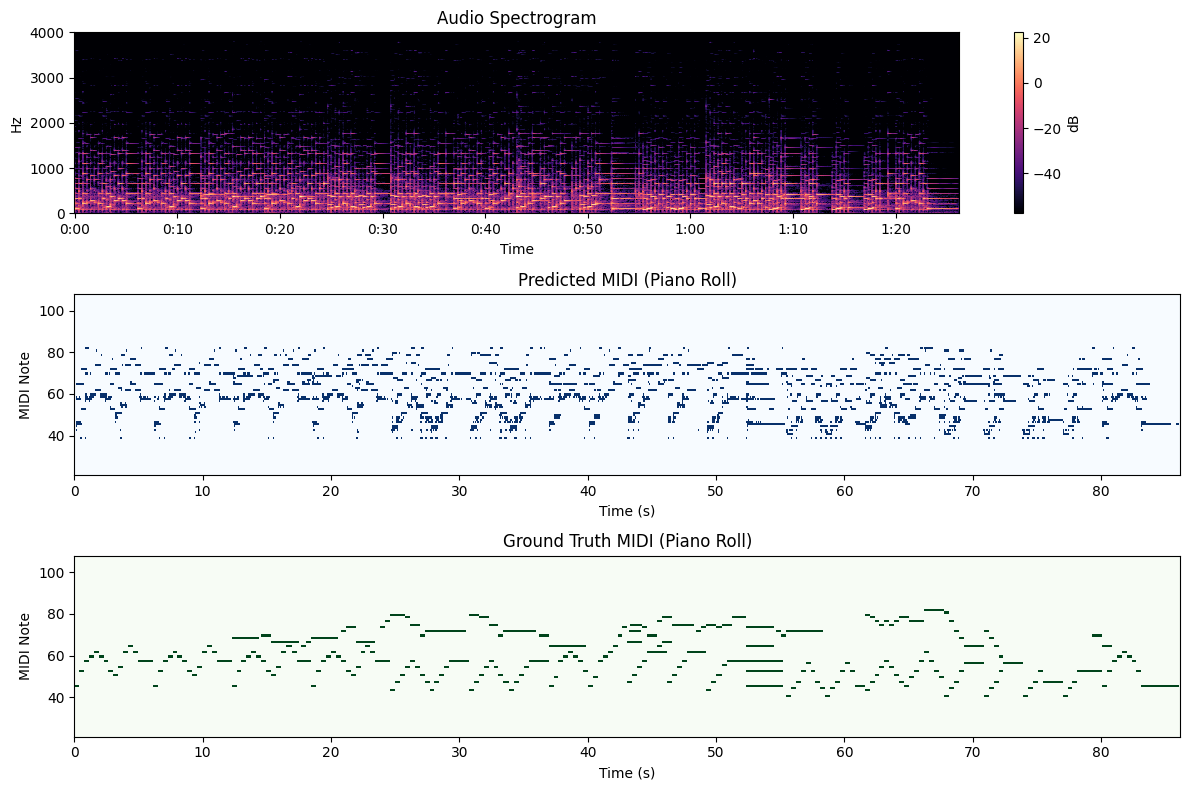

In [11]:
frame_times = librosa.frames_to_time(np.arange(S.shape[1]), sr=sr, hop_length=hop_length)
note_range = (21, 108)

def plot_piano_roll(midi_notes, title, color):
    roll = np.zeros((128, len(frame_times)))
    for note in midi_notes:
        start_idx = int(note.start * sr / hop_length)
        end_idx = int(note.end * sr / hop_length)
        pitch = np.clip(note.pitch, 0, 127)
        roll[pitch, start_idx:end_idx] = 1
    plt.imshow(roll[note_range[0]:note_range[1]], aspect='auto', origin='lower',
               extent=[frame_times[0], frame_times[-1], note_range[0], note_range[1]],
               cmap=color, interpolation='nearest')
    plt.xlabel('Time (s)')
    plt.ylabel('MIDI Note')
    plt.title(title)

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
S_db = librosa.amplitude_to_db(S + 1e-6)
librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(label='dB')
plt.title("Audio Spectrogram")

plt.subplot(3, 1, 2)
plot_piano_roll(piano_inst.notes, "Predicted MIDI (Piano Roll)", 'Blues')

plt.subplot(3, 1, 3)
gt_notes = [note for instr in gt_midi.instruments for note in instr.notes]
plot_piano_roll(gt_notes, "Ground Truth MIDI (Piano Roll)", 'Greens')

plt.tight_layout()
plt.show()

In [12]:
W_fixed, note_names = build_w_fixed("ISOLATED", sr, n_fft, hop_length)
print("W_fixed shape:", W_fixed.shape, "for notes:", note_names)

W_fixed shape: (1025, 88) for notes: ['A#0', 'A#1', 'A#2', 'A#3', 'A#4', 'A#5', 'A#6', 'A#7', 'A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'C#1', 'C#2', 'C#3', 'C#4', 'C#5', 'C#6', 'C#7', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'D#1', 'D#2', 'D#3', 'D#4', 'D#5', 'D#6', 'D#7', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'F#1', 'F#2', 'F#3', 'F#4', 'F#5', 'F#6', 'F#7', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'G#1', 'G#2', 'G#3', 'G#4', 'G#5', 'G#6', 'G#7', 'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7']


In [13]:
R_fixed = W_fixed.shape[1]
H_fixed = np.zeros((R_fixed, S.shape[1]), dtype=np.float32)

for t_idx in range(S.shape[1]):
    S_col = S[:, t_idx]
    h_opt, _ = nnls(W_fixed, S_col)
    H_fixed[:, t_idx] = h_opt

In [14]:
H_fixed_clean = denoise_activations(H_fixed,
                          rel_thresh=0.2,
                          top_k=5,
                          smooth_win=3,
                          min_frames=2)

In [15]:
frame_times = times
pitches_midi = [note_name_to_midi(nm) for nm in note_names]
detected_notes = activations_to_notes(H_fixed_clean,
                                              frame_times,
                                              pitches_midi,
                                              onset_rel_thresh=0.3,
                                              min_frames=2)

print("Detected notes (onset, offset, MIDI pitch):")
for n in detected_notes:
    print(n)

Detected notes (onset, offset, MIDI pitch):
(np.float64(12.416), np.float64(12.544), 46)
(np.float64(18.56), np.float64(18.688), 46)
(np.float64(60.864), np.float64(60.992), 46)
(np.float64(80.128), np.float64(80.256), 46)
(np.float64(0.832), np.float64(0.96), 58)
(np.float64(20.864), np.float64(20.992), 58)
(np.float64(65.856), np.float64(65.984), 58)
(np.float64(66.624), np.float64(66.752), 58)
(np.float64(80.832), np.float64(80.96), 58)
(np.float64(36.288), np.float64(36.416), 70)
(np.float64(42.432), np.float64(42.56), 70)
(np.float64(79.296), np.float64(79.488), 70)
(np.float64(0.128), np.float64(0.576), 45)
(np.float64(6.336), np.float64(6.72), 45)
(np.float64(12.48), np.float64(12.864), 45)
(np.float64(18.624), np.float64(19.072), 45)
(np.float64(37.056), np.float64(37.44), 45)
(np.float64(40.128), np.float64(40.576), 45)
(np.float64(52.48), np.float64(54.464), 45)
(np.float64(60.928), np.float64(61.632), 45)
(np.float64(64.768), np.float64(65.152), 45)
(np.float64(80.192), np.f

In [16]:
midi_object = pretty_midi.PrettyMIDI()
piano_prog = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
piano_inst = pretty_midi.Instrument(program=piano_prog)

for onset, offset, pitch_midi in detected_notes:
    pitch_midi = int(np.clip(round(pitch_midi), 0, 127))
    note = pretty_midi.Note(velocity=100, pitch=pitch_midi, start=onset, end=offset)
    piano_inst.notes.append(note)

midi_object.instruments.append(piano_inst)
midi_object.write("predicted_transcription_fixed.mid")
print("Predicted MIDI saved as predicted_transcription_fixed.mid")

Predicted MIDI saved as predicted_transcription_fixed.mid


In [17]:
pred_midi = pretty_midi.PrettyMIDI("predicted_transcription_fixed.mid")
gt_midi = pretty_midi.PrettyMIDI("wet_hands.mid")

metrics = evaluate_transcription_full(pred_midi, gt_midi)

print("=== Evaluation Results ===")
for category, scores in metrics.items():
    print(f"\n[{category}]")
    for k, v in scores.items():
        print(f"{k}: {v * 100:.2f}%")

=== Evaluation Results ===

[Note_Onset]
P: 36.54%
R: 45.64%
F1: 40.59%

[Frame]
P: 75.94%
R: 56.59%
F1: 64.85%


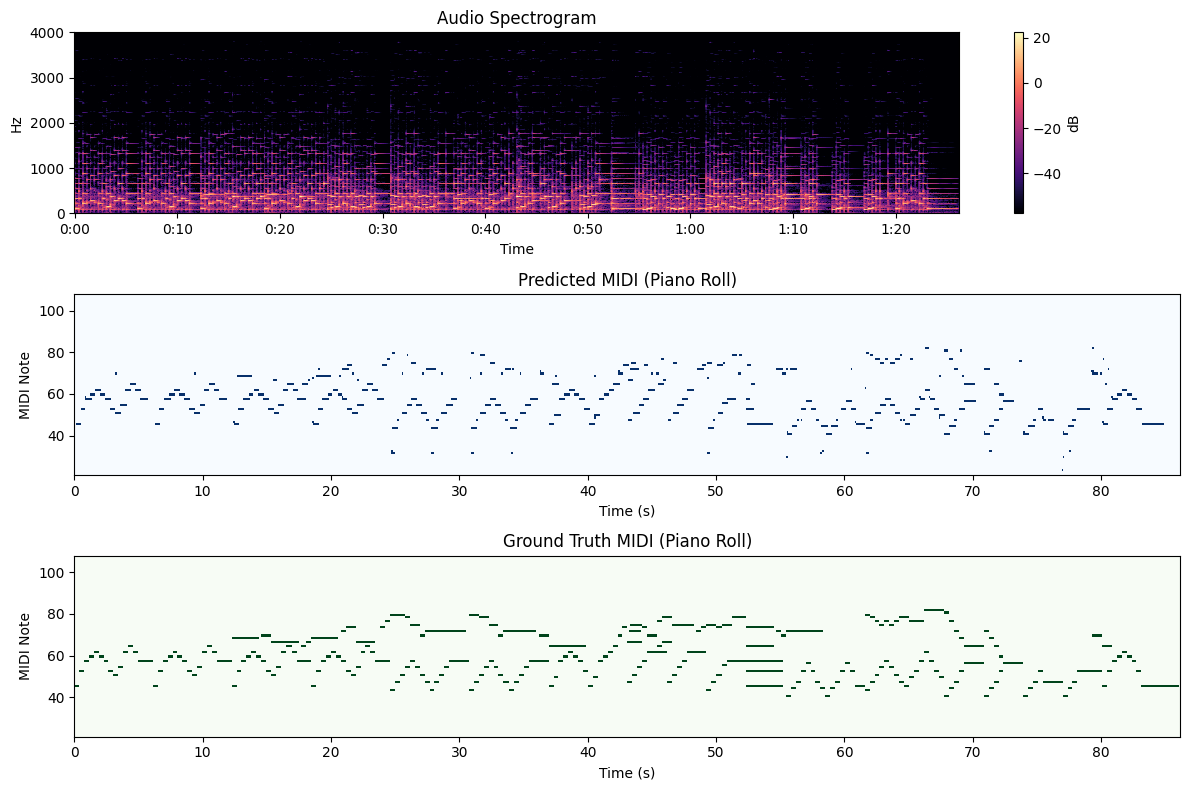

In [18]:
frame_times = librosa.frames_to_time(np.arange(S.shape[1]), sr=sr, hop_length=hop_length)
note_range = (21, 108)

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
S_db = librosa.amplitude_to_db(S + 1e-6)
librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(label='dB')
plt.title("Audio Spectrogram")

plt.subplot(3, 1, 2)
plot_piano_roll(piano_inst.notes, "Predicted MIDI (Piano Roll)", 'Blues')

plt.subplot(3, 1, 3)
gt_notes = [note for instr in gt_midi.instruments for note in instr.notes]
plot_piano_roll(gt_notes, "Ground Truth MIDI (Piano Roll)", 'Greens')

plt.tight_layout()
plt.show()